### Recreate figures using datajoint pipeline

In [1]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aeon.dj_pipeline import acquisition, subject
from aeon.dj_pipeline.analysis import in_arena, visit

[2022-07-15 14:31:13,320][INFO]: Connecting jaeronga@aeon-db2:3306
[2022-07-15 14:31:13,378][INFO]: Connected jaeronga@aeon-db2:3306


In [2]:
experiment_name = "exp0.2-r0"
duration_crit = 24  # in hours

subject_visits = (visit.VisitEnd & f'experiment_name="{experiment_name}"' 
                  & f'visit_duration > {duration_crit}').fetch(order_by='visit_duration', format='frame').reset_index()
subject_visits  # comparison between Chang's subject_visits df. visit_start timestamp is the same, but small difference in visit_end timestamp (Chang's version is ~4 early)

,experiment_name,subject,place,visit_start,visit_end,visit_duration
0,exp0.2-r0,BAA-1100700,environment,2022-02-23 14:21:25.550300,2022-02-25 16:00:50.076419,49.6568
1,exp0.2-r0,BAA-1100701,environment,2022-04-04 15:54:07.945059,2022-04-08 16:34:36.183650,96.6745
2,exp0.2-r0,BAA-1100699,environment,2022-03-29 13:11:37.277699,2022-04-04 09:16:51.086110,140.0870
3,exp0.2-r0,BAA-1100699,environment,2022-04-20 11:51:24.997630,2022-04-28 10:02:56.655809,190.1920
4,exp0.2-r0,BAA-1100702,environment,2022-05-03 11:08:12.660739,2022-05-12 09:21:42.411650,214.2250
5,exp0.2-r0,BAA-1100703,environment,2022-05-25 08:59:51.050459,2022-06-06 07:55:37.501309,286.9300


In [90]:
patch_serial_numbers = (acquisition.ExperimentFoodPatch & 
 f'experiment_name="{experiment_name}"').fetch("food_patch_serial_number")

food_patch_descriptions = (acquisition.ExperimentFoodPatch & 
 f'experiment_name="{experiment_name}"').fetch("food_patch_description")

- In exp0.2-r0, there are 16 visits by 5 animals. 5 visits whose duration > 24 hr

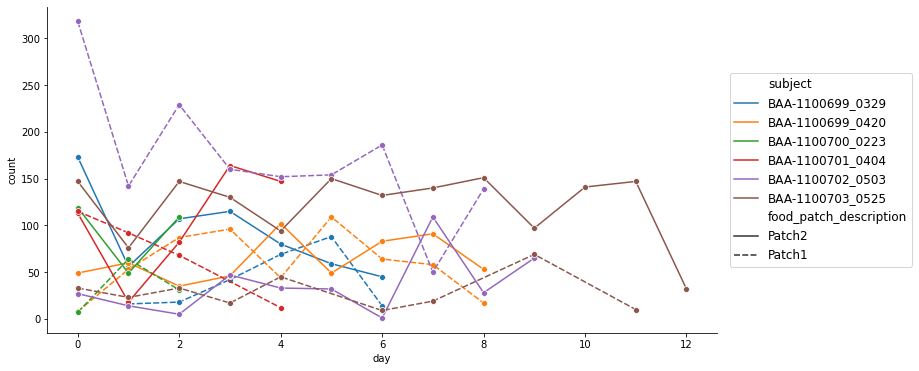

In [158]:
# plot daily pellet count
pellet_df = pd.DataFrame() 
columns = ["food_patch_description", "event_time"]

visit_dict = (visit.VisitEnd & f'experiment_name="{experiment_name}"' & f'visit_duration > {duration_crit}').fetch("subject", "visit_start", "visit_end", as_dict=True)

for _ in visit_dict: 
    subject, visit_start, visit_end = _["subject"], _["visit_start"], _["visit_end"]
    # print((subject, visit_start, visit_end))
    
    temp_df = ((acquisition.FoodPatchEvent * acquisition.EventType) * (acquisition.ExperimentFoodPatch.proj('food_patch_description')) \
    & f'experiment_name = "{experiment_name}"' \
    & 'event_type = "TriggerPellet"' \
    & f'event_time BETWEEN "{visit_start}" AND "{visit_end}"'    
    ).fetch(format="frame").reset_index()[columns]
    
    temp_df["subject"] = '_'.join([subject, visit_start.strftime("%m%d")])
    temp_df["day"] = temp_df["event_time"].apply(lambda x: pd.Timestamp(x).date())
    temp_df["day"] -= temp_df["day"].min()
    temp_df["day"] = temp_df["day"].dt.days
    temp_df.set_index("event_time", inplace=True)
    pellet_df = pd.concat([pellet_df, temp_df])

pellet_count = (
    pellet_df.groupby(["subject", "day", "food_patch_description"])
    .size()
    .reset_index(name="count")
)

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(
    data=pellet_count,
    x="day",
    y="count",
    hue="subject",
    style="food_patch_description",
    ax=ax,
    marker="o",
)

ax.legend(loc='center left', 
        bbox_to_anchor=(1.01, 0.5), prop={'size': 12},
) 
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

In [29]:
pellet_count
# pellet_count.to_csv('pellet_count_dj.csv')

,subject,day,food_patch_serial_number,count
0,BAA-1100699_0329,0,COM7,173
1,BAA-1100699_0329,1,COM4,16
2,BAA-1100699_0329,1,COM7,56
3,BAA-1100699_0329,2,COM4,18
4,BAA-1100699_0329,2,COM7,107
...,...,...,...,...
82,BAA-1100703_0525,9,COM7,97
83,BAA-1100703_0525,10,COM7,141
84,BAA-1100703_0525,11,COM4,10
85,BAA-1100703_0525,11,COM7,147


In [131]:
acquisition.FoodPatchEvent * acquisition.EventType

experiment_name e.g exp0-a,chunk_start datetime of the start of a given acquisition chunk,food_patch_serial_number,food_patch_install_time time of the food_patch placed and started operation at this position,event_number,event_code,event_time event time,event_type
exp0.1-r0,2021-06-03 08:00:00,COM4,2021-06-02 23:49:41,1,32,2021-06-03 08:03:40.614624,PelletDetected
exp0.1-r0,2021-06-03 08:00:00,COM4,2021-06-02 23:49:41,2,32,2021-06-03 08:03:40.644192,PelletDetected
exp0.1-r0,2021-06-03 08:00:00,COM4,2021-06-02 23:49:41,4,32,2021-06-03 08:07:56.285855,PelletDetected
exp0.1-r0,2021-06-03 08:00:00,COM7,2021-06-02 23:49:41,1,32,2021-06-03 08:03:42.268767,PelletDetected
exp0.1-r0,2021-06-03 08:00:00,COM7,2021-06-02 23:49:41,2,32,2021-06-03 08:03:42.324736,PelletDetected
exp0.1-r0,2021-06-03 08:00:00,COM7,2021-06-02 23:49:41,4,32,2021-06-03 08:07:59.155935,PelletDetected
exp0.1-r0,2021-06-03 10:00:00,COM4,2021-06-02 23:49:41,1,32,2021-06-03 10:08:18.641823,PelletDetected
exp0.1-r0,2021-06-03 10:00:00,COM4,2021-06-02 23:49:41,2,32,2021-06-03 10:08:18.778048,PelletDetected
exp0.1-r0,2021-06-03 10:00:00,COM4,2021-06-02 23:49:41,4,32,2021-06-03 10:11:40.341248,PelletDetected
exp0.1-r0,2021-06-03 10:00:00,COM4,2021-06-02 23:49:41,6,32,2021-06-03 10:12:02.062143,PelletDetected


In [132]:
(acquisition.FoodPatchEvent * acquisition.EventType) * (acquisition.ExperimentFoodPatch.proj('food_patch_description'))

experiment_name e.g exp0-a,chunk_start datetime of the start of a given acquisition chunk,food_patch_serial_number,food_patch_install_time time of the food_patch placed and started operation at this position,event_number,event_code,event_time event time,event_type,food_patch_description
exp0.1-r0,2021-06-03 08:00:00,COM4,2021-06-02 23:49:41,1,32,2021-06-03 08:03:40.614624,PelletDetected,Patch1
exp0.1-r0,2021-06-03 08:00:00,COM4,2021-06-02 23:49:41,2,32,2021-06-03 08:03:40.644192,PelletDetected,Patch1
exp0.1-r0,2021-06-03 08:00:00,COM4,2021-06-02 23:49:41,4,32,2021-06-03 08:07:56.285855,PelletDetected,Patch1
exp0.1-r0,2021-06-03 10:00:00,COM4,2021-06-02 23:49:41,1,32,2021-06-03 10:08:18.641823,PelletDetected,Patch1
exp0.1-r0,2021-06-03 10:00:00,COM4,2021-06-02 23:49:41,2,32,2021-06-03 10:08:18.778048,PelletDetected,Patch1
exp0.1-r0,2021-06-03 10:00:00,COM4,2021-06-02 23:49:41,4,32,2021-06-03 10:11:40.341248,PelletDetected,Patch1
exp0.1-r0,2021-06-03 10:00:00,COM4,2021-06-02 23:49:41,6,32,2021-06-03 10:12:02.062143,PelletDetected,Patch1
exp0.1-r0,2021-06-03 10:00:00,COM4,2021-06-02 23:49:41,8,32,2021-06-03 10:12:22.640255,PelletDetected,Patch1
exp0.1-r0,2021-06-03 10:00:00,COM4,2021-06-02 23:49:41,10,32,2021-06-03 10:12:35.818624,PelletDetected,Patch1
exp0.1-r0,2021-06-03 10:00:00,COM4,2021-06-02 23:49:41,12,32,2021-06-03 10:12:52.634880,PelletDetected,Patch1


- Numbers are slightly off compared to the ones generated from the Chang's code. This needs to be checked.

In [142]:
subject_visits

,experiment_name,subject,place,visit_start,visit_end,visit_duration
0,exp0.2-r0,BAA-1100700,environment,2022-02-23 14:21:25.550300,2022-02-25 16:00:50.076419,49.6568
1,exp0.2-r0,BAA-1100701,environment,2022-04-04 15:54:07.945059,2022-04-08 16:34:36.183650,96.6745
2,exp0.2-r0,BAA-1100699,environment,2022-03-29 13:11:37.277699,2022-04-04 09:16:51.086110,140.0870
3,exp0.2-r0,BAA-1100699,environment,2022-04-20 11:51:24.997630,2022-04-28 10:02:56.655809,190.1920
4,exp0.2-r0,BAA-1100702,environment,2022-05-03 11:08:12.660739,2022-05-12 09:21:42.411650,214.2250
5,exp0.2-r0,BAA-1100703,environment,2022-05-25 08:59:51.050459,2022-06-06 07:55:37.501309,286.9300


In [7]:
(in_arena.InArenaEnd) & f'experiment_name = "{experiment_name}"' & f'in_arena_duration > 24'
# (in_arena.InArenaEnd) & f'experiment_name = "{experiment_name}"'
# why is different from visit end?

experiment_name e.g exp0-a,subject,in_arena_start,in_arena_end,in_arena_duration (hour)
exp0.2-r0,BAA-1100699,2022-04-20 11:51:24.997630,2022-04-28 10:02:56.655809,190.192
exp0.2-r0,BAA-1100701,2022-04-04 15:54:07.945059,2022-04-08 16:34:36.183650,96.6745
exp0.2-r0,BAA-1100702,2022-05-03 11:08:12.660739,2022-05-12 09:21:42.411650,214.225
exp0.2-r0,BAA-1100703,2022-05-25 08:59:51.050459,2022-06-06 07:55:37.501309,286.93


In [40]:
query = visit.VisitEnd * in_arena.InArenaEnd & f'experiment_name="{experiment_name}"' & f'in_arena_duration > 24'
query.fetch(format="frame").reset_index().drop(columns="in_arena_duration")

# .rename({"visit_duration" : "in_arena_duration"})

,experiment_name,subject,place,visit_start,in_arena_start,visit_end,visit_duration,in_arena_end
0,exp0.2-r0,BAA-1100699,environment,2022-03-29 13:11:37.277699,2022-04-20 11:51:24.997630,2022-04-04 09:16:51.086110,140.08700,2022-04-28 10:02:56.655809
1,exp0.2-r0,BAA-1100699,environment,2022-04-20 11:51:24.997630,2022-04-20 11:51:24.997630,2022-04-28 10:02:56.655809,190.19200,2022-04-28 10:02:56.655809
2,exp0.2-r0,BAA-1100701,environment,2022-04-04 13:59:13.352029,2022-04-04 15:54:07.945059,2022-04-04 15:19:41.652349,1.34119,2022-04-08 16:34:36.183650
3,exp0.2-r0,BAA-1100701,environment,2022-04-04 15:54:07.945059,2022-04-04 15:54:07.945059,2022-04-08 16:34:36.183650,96.67450,2022-04-08 16:34:36.183650
4,exp0.2-r0,BAA-1100701,environment,2022-04-29 09:37:50.754849,2022-04-04 15:54:07.945059,2022-04-29 12:40:51.436289,3.05019,2022-04-08 16:34:36.183650
5,exp0.2-r0,BAA-1100702,environment,2022-05-03 11:08:12.660739,2022-05-03 11:08:12.660739,2022-05-12 09:21:42.411650,214.22500,2022-05-12 09:21:42.411650
6,exp0.2-r0,BAA-1100703,environment,2022-05-25 08:59:51.050459,2022-05-25 08:59:51.050459,2022-06-06 07:55:37.501309,286.93000,2022-06-06 07:55:37.501309


In [16]:
(in_arena.InArena) & f'experiment_name = "{experiment_name}"' 

experiment_name e.g exp0-a,subject,in_arena_start,task_protocol
exp0.2-r0,BAA-1100699,2022-03-29 13:11:37.277699,None
exp0.2-r0,BAA-1100699,2022-04-20 11:51:24.997630,None
exp0.2-r0,BAA-1100700,2022-02-23 14:21:25.550300,None
exp0.2-r0,BAA-1100700,2022-03-02 13:47:43.875840,None
exp0.2-r0,BAA-1100700,2022-03-04 14:00:01.818980,None
exp0.2-r0,BAA-1100700,2022-03-04 14:04:16.610499,None
exp0.2-r0,BAA-1100700,2022-03-15 12:40:36.282139,None
exp0.2-r0,BAA-1100700,2022-03-16 15:06:37.790820,None
exp0.2-r0,BAA-1100700,2022-03-17 15:56:35.478690,None
exp0.2-r0,BAA-1100700,2022-03-23 14:47:58.253819,None


In [15]:
(in_arena.InArenaEnd) & f'experiment_name = "{experiment_name}"' 

experiment_name e.g exp0-a,subject,in_arena_start,in_arena_end,in_arena_duration (hour)
exp0.2-r0,BAA-1100699,2022-04-20 11:51:24.997630,2022-04-28 10:02:56.655809,190.192
exp0.2-r0,BAA-1100700,2022-03-04 14:00:01.818980,2022-03-04 14:00:49.259260,0.0131779
exp0.2-r0,BAA-1100700,2022-03-15 12:40:36.282139,2022-03-15 15:56:55.801119,3.27209
exp0.2-r0,BAA-1100700,2022-03-16 15:06:37.790820,2022-03-16 16:44:50.910079,1.63698
exp0.2-r0,BAA-1100700,2022-03-17 15:56:35.478690,2022-03-17 17:41:48.763070,1.75369
exp0.2-r0,BAA-1100700,2022-03-23 14:47:58.253819,2022-03-24 14:08:54.449150,23.3489
exp0.2-r0,BAA-1100700,2022-04-29 09:37:08.806660,2022-04-29 12:40:39.900259,3.05864
exp0.2-r0,BAA-1100701,2022-04-04 13:59:13.352029,2022-04-04 15:19:41.652349,1.34119
exp0.2-r0,BAA-1100701,2022-04-04 15:54:07.945059,2022-04-08 16:34:36.183650,96.6745
exp0.2-r0,BAA-1100701,2022-04-29 09:37:50.754849,2022-04-29 12:40:51.436289,3.05019


In [172]:
in_arena.InArenaSubjectPosition().fetch("position_x")[0][0:3]

array([227.71281, 227.20415, 226.84782], dtype=float32)

In [55]:
position_x = in_arena.InArenaSubjectPosition().fetch("position_x")


In [56]:
len(position_x)

3

In [122]:
(in_arena.InArenaTimeSlice() & f'experiment_name="{experiment_name}"').fetch

experiment_name e.g exp0-a,subject,in_arena_start,chunk_start datetime of the start of a given acquisition chunk,time_slice_start datetime of the start of this time slice,time_slice_end datetime of the end of this time slice
exp0.2-r0,BAA-1100699,2022-04-20 11:51:24.997630,2022-04-20 11:00:00,2022-04-20 11:51:24.997630,2022-04-20 12:00:00
exp0.2-r0,BAA-1100699,2022-04-20 11:51:24.997630,2022-04-20 12:00:00,2022-04-20 12:00:00,2022-04-20 12:10:00
exp0.2-r0,BAA-1100699,2022-04-20 11:51:24.997630,2022-04-20 12:00:00,2022-04-20 12:10:00,2022-04-20 12:20:00
exp0.2-r0,BAA-1100699,2022-04-20 11:51:24.997630,2022-04-20 12:00:00,2022-04-20 12:20:00,2022-04-20 12:30:00
exp0.2-r0,BAA-1100699,2022-04-20 11:51:24.997630,2022-04-20 12:00:00,2022-04-20 12:30:00,2022-04-20 12:40:00
exp0.2-r0,BAA-1100699,2022-04-20 11:51:24.997630,2022-04-20 12:00:00,2022-04-20 12:40:00,2022-04-20 12:50:00
exp0.2-r0,BAA-1100699,2022-04-20 11:51:24.997630,2022-04-20 12:00:00,2022-04-20 12:50:00,2022-04-20 13:00:00
exp0.2-r0,BAA-1100699,2022-04-20 11:51:24.997630,2022-04-20 13:00:00,2022-04-20 13:00:00,2022-04-20 13:10:00
exp0.2-r0,BAA-1100699,2022-04-20 11:51:24.997630,2022-04-20 13:00:00,2022-04-20 13:10:00,2022-04-20 13:20:00
exp0.2-r0,BAA-1100699,2022-04-20 11:51:24.997630,2022-04-20 13:00:00,2022-04-20 13:20:00,2022-04-20 13:30:00


In [134]:
# plot daily wheel distance travelled

wheel_df = pd.DataFrame() 

visit_dict = (visit.VisitEnd & f'experiment_name="{experiment_name}"' \
    & f'visit_duration > {duration_crit}'
    ).fetch("subject", "visit_start", "visit_end", as_dict=True)

for _ in visit_dict: 
    subject, visit_start, visit_end = _["subject"], _["visit_start"], _["visit_end"]
    print((subject, visit_start, visit_end))
    for patch_name in patch_names:
        
        wheel_data = acquisition.FoodPatchWheel.get_wheel_data(
            experiment_name=experiment_name,
            start=pd.Timestamp(visit_start),
            end=pd.Timestamp(visit_end),
            patch_name=patch_name,
            using_aeon_io=False,
        )
    
        break
    break

# takes a very long time to run

In [ ]:
# plot daily distance travelled (activity)
pixel_scale = 0.00192  # 1 px = 1.92 mm
position_df = pd.DataFrame()

for i in range(len(subject_visits)):
    pos = get_data(exp02.CameraTop.Position, i)
    pos = pos[
        (pos["area"] > 0) & (pos["area"] < 1000)
    ]  # filter for objects of the correct size
    pos["x"] *= pixel_scale
    pos["y"] *= pixel_scale
    pos_diff = np.sqrt(np.square(np.diff(pos["x"]) + np.square(np.diff(pos["y"]))))
    pos["diff"] = np.concatenate([[0], pos_diff])
    position_df = pd.concat([position_df, pos])

position_df["day"] = (position_df.index.date - position_df["day"]).dt.days

activity = position_df.groupby(["id", "day"])["diff"].sum().reset_index(name="dist")

# fig, ax = plt.subplots(figsize=(12, 6))
# sns.lineplot(
#     data=activity,
#     x="day",
#     y="dist",
#     hue="id",
#     ax=ax,
#     marker="o",
# )


In [ ]:
# # plot daily distance travelled (activity) # Chang's code
# pixel_scale = 0.00192  # 1 px = 1.92 mm
# positions = pd.DataFrame()
# for i in range(len(subject_visits)):
#     pos = get_data(exp02.CameraTop.Position, i)
#     pos = pos[
#         (pos["area"] > 0) & (pos["area"] < 1000)
#     ]  # filter for objects of the correct size
#     pos["x"] *= pixel_scale
#     pos["y"] *= pixel_scale
#     pos_diff = np.sqrt(np.square(np.diff(pos["x"]) + np.square(np.diff(pos["y"]))))
#     pos["diff"] = np.concatenate([[0], pos_diff])
#     positions = pd.concat([positions, pos])

# positions["day"] = (positions.index.date - positions["day"]).dt.days

# activity = positions.groupby(["id", "day"])["diff"].sum().reset_index(name="dist")

# fig, ax = plt.subplots(figsize=(12, 6))
# sns.lineplot(
#     data=activity,
#     x="day",
#     y="dist",
#     hue="id",
#     ax=ax,
#     marker="o",
# )


In [163]:
(in_arena.InArena * in_arena.InArenaEnd).fetch('in_arena_duration')[:10]

array([4.68008  , 4.83148  , 4.32187  , 5.21997  , 4.53942  , 4.44546  ,
       5.40079  , 4.95307  , 5.21128  , 0.0736448])

experiment_name e.g exp0-a,subject,in_arena_start,chunk_start datetime of the start of a given acquisition chunk,time_slice_start datetime of the start of this time slice,time_slice_end datetime of the end of this time slice
exp0.2-r0,BAA-1100699,2022-04-20 11:51:24.997630,2022-04-20 11:00:00,2022-04-20 11:51:24.997630,2022-04-20 12:00:00
exp0.2-r0,BAA-1100699,2022-04-20 11:51:24.997630,2022-04-20 12:00:00,2022-04-20 12:00:00,2022-04-20 12:10:00
exp0.2-r0,BAA-1100699,2022-04-20 11:51:24.997630,2022-04-20 12:00:00,2022-04-20 12:10:00,2022-04-20 12:20:00
exp0.2-r0,BAA-1100699,2022-04-20 11:51:24.997630,2022-04-20 12:00:00,2022-04-20 12:20:00,2022-04-20 12:30:00
exp0.2-r0,BAA-1100699,2022-04-20 11:51:24.997630,2022-04-20 12:00:00,2022-04-20 12:30:00,2022-04-20 12:40:00
exp0.2-r0,BAA-1100699,2022-04-20 11:51:24.997630,2022-04-20 12:00:00,2022-04-20 12:40:00,2022-04-20 12:50:00
exp0.2-r0,BAA-1100699,2022-04-20 11:51:24.997630,2022-04-20 12:00:00,2022-04-20 12:50:00,2022-04-20 13:00:00
exp0.2-r0,BAA-1100699,2022-04-20 11:51:24.997630,2022-04-20 13:00:00,2022-04-20 13:00:00,2022-04-20 13:10:00
exp0.2-r0,BAA-1100699,2022-04-20 11:51:24.997630,2022-04-20 13:00:00,2022-04-20 13:10:00,2022-04-20 13:20:00
exp0.2-r0,BAA-1100699,2022-04-20 11:51:24.997630,2022-04-20 13:00:00,2022-04-20 13:20:00,2022-04-20 13:30:00


In [159]:
(in_arena.InArenaSubjectPosition() & 'experiment_name="exp0.2-r0"').fetch1()

DataJointError: fetch1 requires exactly one tuple in the input set.